<a href="https://colab.research.google.com/github/Neotemplate/awesome-projects/blob/main/01_Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Age**: age of the patient [years]

**Sex**: sex of the patient [M: Male, F: Female]

**ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

**RestingBP**: resting blood pressure [mm Hg]

**Cholesterol**: serum cholesterol [mm/dl]

**FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

**RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

**MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]

**ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]

**Oldpeak**: oldpeak = ST [Numeric value measured in depression]

**ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

**HeartDisease**: output class [1: heart disease, 0: Normal]

In [102]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_curve, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [103]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    mi_scores.plot.bar()
    return mi_scores

def predict_proba(model):
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  print(f'--Classification Report--\n\n{classification_report(y_test, predictions)}')
  cm = confusion_matrix(y_test, predictions, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  cross = cross_val_score(model, X, y, cv=5)
  print(f'--Cross validation metrics--\n\n{cross}')
  print(f'Mean: {cross.mean()}')
  predictionsP = model.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, predictionsP[:, 1])
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=str(model).split('(')[0])
  display.plot()
  plt.show()
  plt.clf()

In [104]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [105]:
#basic information of the dataset

df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [107]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [108]:
#List of all numerical features to make analysis easier on the going
numerical_features = [x for x in df.columns if df[x].dtype =='int64' or df[x].dtype =='float64']
print(f'--Numerical Features--\n\n{numerical_features}\n\n')

#Same here with categorical features
object_features = [x for x in df.columns if df[x].dtype =='object']
print(f'--Object Features--\n\n{object_features}\n\n')

#Checking for outiliers
print(f'---Minimum values--- \n\n {df[numerical_features].min()}\n\n')
print(f'---Max values---\n\n{df[numerical_features].max()}\n\n')

--Numerical Features--

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


--Object Features--

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


---Minimum values--- 

 Age             28.0
RestingBP        0.0
Cholesterol      0.0
FastingBS        0.0
MaxHR           60.0
Oldpeak         -2.6
HeartDisease     0.0
dtype: float64


---Max values---

Age              77.0
RestingBP       200.0
Cholesterol     603.0
FastingBS         1.0
MaxHR           202.0
Oldpeak           6.2
HeartDisease      1.0
dtype: float64




In [109]:
df[df[numerical_features]==0].count()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

In [110]:
#Impute are necessary in Cholesterol feature, 
#probably because the data was not collected in some cases. 

#If we need to impute some missing data to not loose some important observations, 
#is better to do with observation that has the same diagnostics,

df['Cholesterol'].replace(0, np.NaN, inplace = True)
c0 = df['Cholesterol'][df['HeartDisease']==0].mean()
c1 = df['Cholesterol'][df['HeartDisease']==1].mean()
print(f'Cholesterol mean without heart disease: {c0}')
print(f'Cholesterol mean with heart disease: {c1}')


df0 = df[df['HeartDisease']==0]
df1 = df[df['HeartDisease']==1]

df0['Cholesterol'].fillna(c0, inplace=True)
df1['Cholesterol'].fillna(c1, inplace=True)

imp_df = pd.concat([df0, df1])
imp_df.sort_index(inplace=True)

Cholesterol mean without heart disease: 238.76923076923077
Cholesterol mean with heart disease: 251.06179775280899


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [111]:
#We have 5 categorical data. The ML algorithm will not recognize it if changes not be made.
imp_df_d = pd.get_dummies(imp_df)

In [112]:
imp_df_d.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214.0,0,108,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195.0,0,122,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


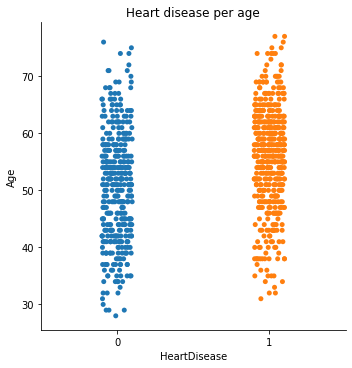

<Figure size 432x288 with 0 Axes>

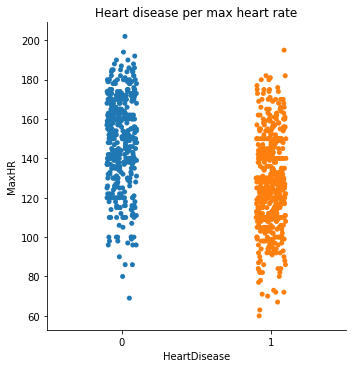

<Figure size 432x288 with 0 Axes>

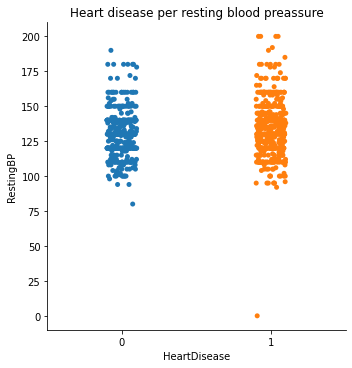

<Figure size 432x288 with 0 Axes>

In [113]:
#some graphs to get some insights from data

sns.catplot(x='HeartDisease', y='Age', data=imp_df_d, kind='strip')
plt.title('Heart disease per age')
plt.show()
plt.clf()

sns.catplot(x='HeartDisease', y='MaxHR', data=imp_df_d, kind='strip')
plt.title('Heart disease per max heart rate')
plt.show()
plt.clf()

sns.catplot(x='HeartDisease', y='RestingBP', data=imp_df_d, kind='strip')
plt.title('Heart disease per resting blood preassure')
plt.show()
plt.clf()

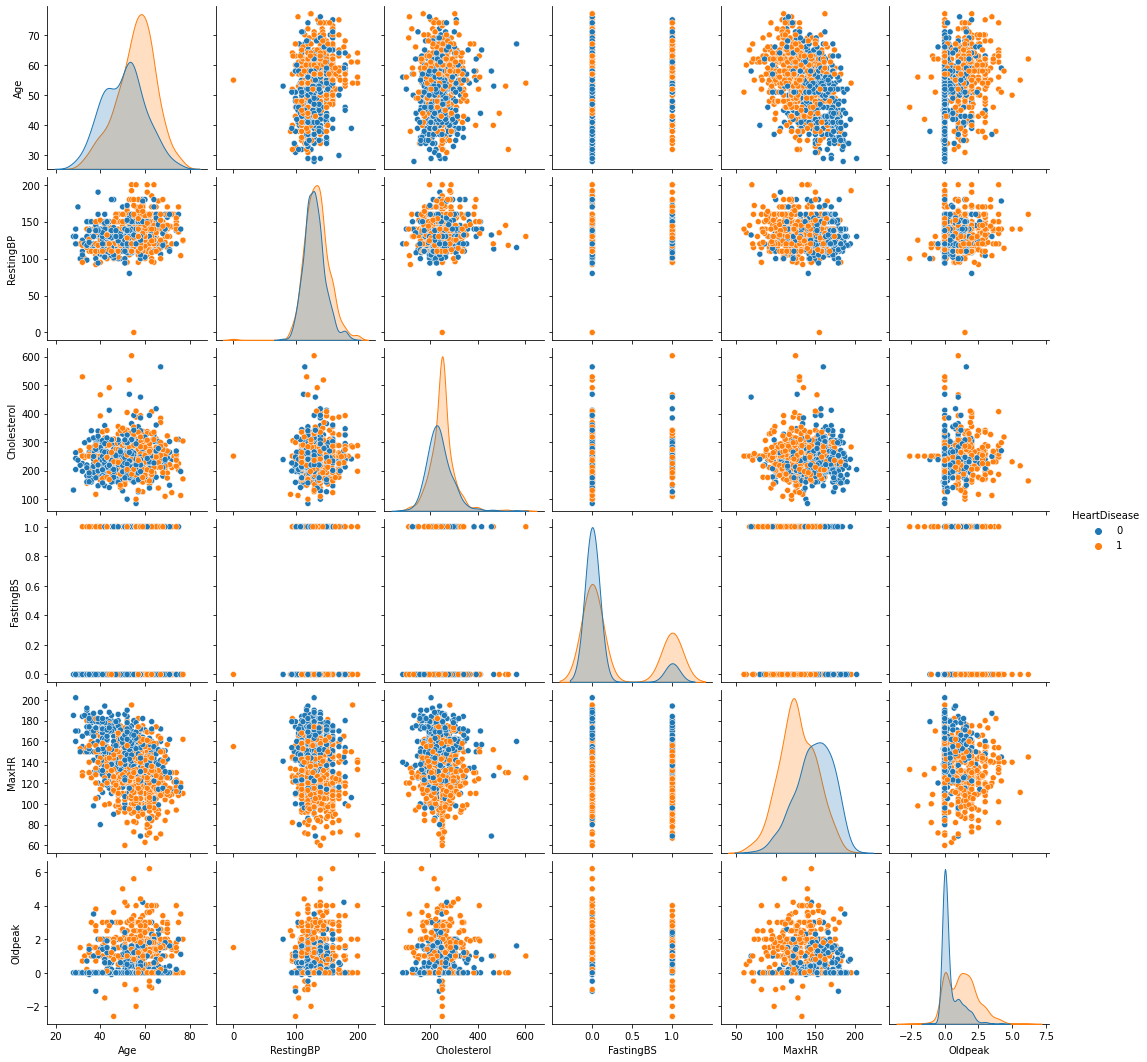

In [114]:
sns.pairplot(imp_df,hue='HeartDisease')

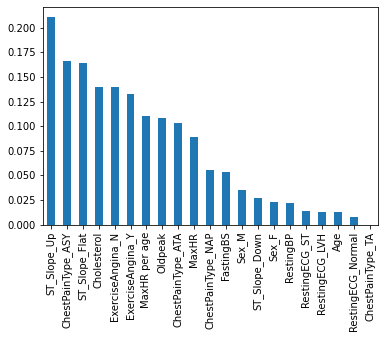

In [115]:
#Add a colum of rate MAX HR / AGE
imp_df_d['MaxHR per age'] = imp_df_d['MaxHR']/imp_df_d['Age']

#Prepare data for modeling

X = imp_df_d.copy()
y = X.pop('HeartDisease')

#Make train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

#MI Scores and ML

mi = make_mi_scores(X_train, y_train)

--Classification Report--

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       102
           1       0.83      0.93      0.88       128

    accuracy                           0.85       230
   macro avg       0.86      0.84      0.85       230
weighted avg       0.86      0.85      0.85       230

--Cross validation metrics--

[0.89673913 0.86413043 0.875      0.85245902 0.75409836]
Mean: 0.8484853884533143


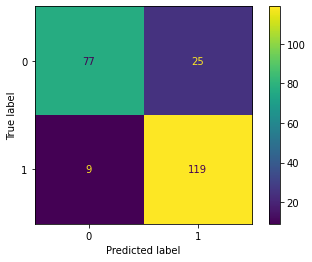

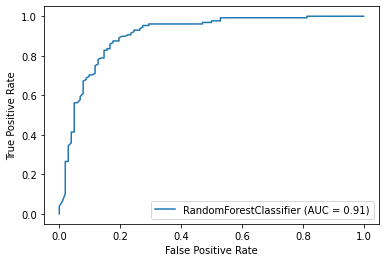

<Figure size 432x288 with 0 Axes>

In [116]:
modelR = RandomForestClassifier(n_estimators=500, 
                                criterion='gini')

predict_proba(modelR)

--Classification Report--

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       102
           1       0.82      0.90      0.86       128

    accuracy                           0.83       230
   macro avg       0.84      0.83      0.83       230
weighted avg       0.84      0.83      0.83       230

--Cross validation metrics--

[0.89130435 0.85869565 0.82608696 0.86338798 0.74863388]
Mean: 0.8376217628890472


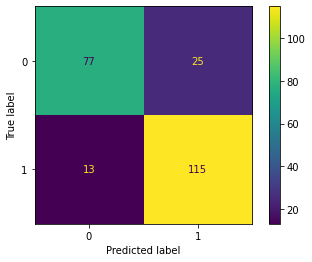

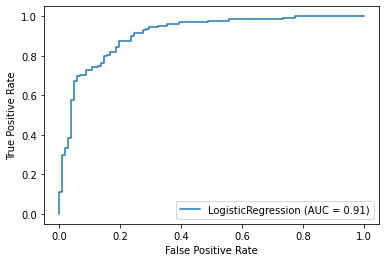

<Figure size 432x288 with 0 Axes>

In [117]:
modelL = LogisticRegression(solver='liblinear')

predict_proba(modelL)

--Classification Report--

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       102
           1       0.82      0.93      0.87       128

    accuracy                           0.85       230
   macro avg       0.86      0.84      0.84       230
weighted avg       0.85      0.85      0.85       230

--Cross validation metrics--

[0.8423913  0.89673913 0.85326087 0.82513661 0.73224044]
Mean: 0.8299536707056309


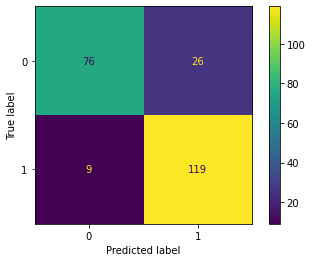

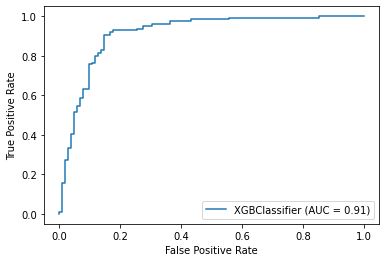

<Figure size 432x288 with 0 Axes>

In [118]:
modelX = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', eta = 0.05, max_depth = 6, n_estimators=300)

predict_proba(modelX)